# Preparing the Data

This notebook demonstrates how I would perform initial preprocessing of the LWF images for ingestion into a machine learning algorithm. This will only serve as a demonstration as scikit-learn has a built in loader for this particular dataset (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) and it is simply more efficient to work with their existing code.

The pre-processing will involve 4 stages:
1. Flattening the images to greyscale
2. Locating the faces within the image
3. Cropping the faces (i.e. removing the background)
4. Representing the images as equal sized vectors

A deeper analysis could involve image registration (i.e. alignment) but LFW provides a funnelled version of the dataset, and frontalization.

The code uses OpenCV and is based off the following github submission: https://github.com/shantnu/FaceDetect/blob/master/face_detect_cv3.py

In [1]:
import numpy as np
import os
import itertools
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### Function to find a single face within an image

In [2]:
# This xml file is from shantnu's github submission above, although it should be a part of openCV
cascPath = "haarcascade_frontalface_default.xml" 
faceCascade = cv2.CascadeClassifier(cascPath)
def find_face(image):
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor = 1.11,
        minNeighbors = 11,
        minSize = (35,35)
    )
    return faces[0] # Note there should be error handling at this point in case zero faces are found

#### Demonstration of face detection

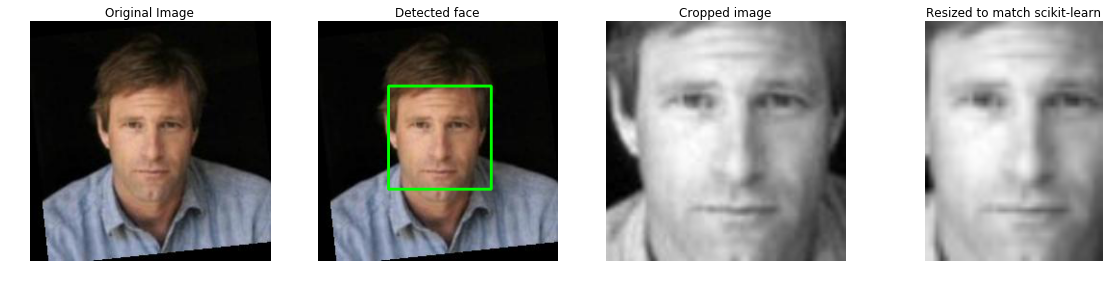

In [32]:
# I could not get a relative path to work and so this needs to be changed if run on a different computer
path = r"C:\Users\Carla\Desktop\Dan\LFW\lfw-deepfunneled" 

image = cv2.imread(path + r"\Aaron_Eckhart\Aaron_Eckhart_0001.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
x, y, w, h = find_face(gray)
image_rect = image.copy()
cv2.rectangle(image_rect, (x, y), (x+w, y+h), (0, 255, 0), 2)
cropped = gray[x:x+w,y:y+h]
more_cropped = cv2.resize(cropped, (50,50))[:,6:-7]


fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)
ax = plt.subplot2grid((1, 4), (0, 0))
ax.axis('off')
ax.set_title('Original Image')
plt.imshow(image[:,:,::-1])
ax = plt.subplot2grid((1, 4), (0, 1))
ax.axis('off')
ax.set_title('Detected face')
plt.imshow(image_rect[:,:,::-1])
ax = plt.subplot2grid((1, 4), (0, 2))
ax.axis('off')
ax.set_title('Cropped image')
plt.imshow(cropped, cmap='gray')
ax = plt.subplot2grid((1, 4), (0, 3))
ax.axis('off')
ax.set_title('Resized to match scikit-learn')
plt.imshow(more_cropped, cmap='gray')

plt.tight_layout()

#### Preprocessing of full image database

In [9]:
def preprocess_face_images(path, number_to_demo):
    
    def make_vector(image):
        temp = np.array(cv2.resize(image, (50,50)))
        return temp[:,6:-7].reshape(-1,1) # This is purely based on the dimensions of the sklearn Loader
    
    counter = 0
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            image = cv2.imread(os.sep.join([dirpath, filename]))
            
            # 1. Make the image greyscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # 2. Locate the face within the image
            x, y, w, h = find_face(gray)
            
            # 3. Crop the image
            cropped = gray[x:x+w,y:y+h]
            
            # 4. Make a uniform sizeded vector
            faces.append(make_vector(cropped))
            
            counter += 1
            if counter == number_to_demo:
                return faces

col_total = 5
number_to_demo = 5*col_total
faces = preprocess_face_images(path, number_to_demo)

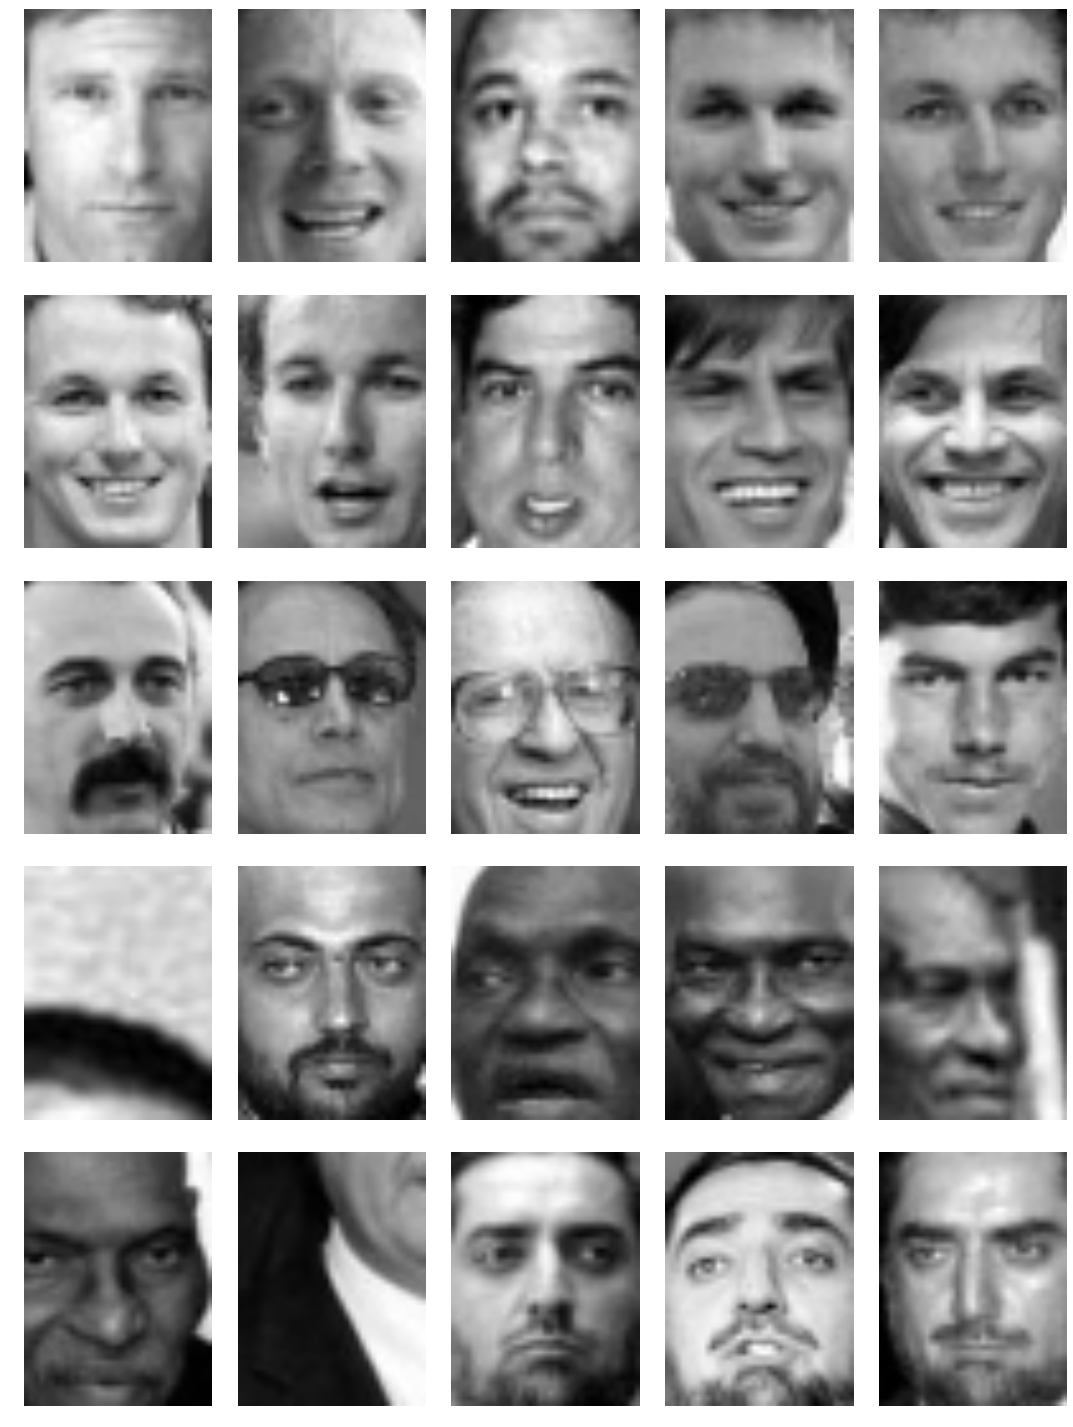

In [10]:
fig = plt.figure()
row_total = int(number_to_demo/col_total)
fig.set_figheight(4*row_total)
fig.set_figwidth(3*col_total)
for row, col in itertools.product(range(row_total), range(col_total)):
    ax = plt.subplot2grid((row_total, col_total), (row, col))
    ax.axis('off')
    face = faces[row*col_total + col]
    plt.imshow(face.reshape(50,37),cmap='gray')

plt.tight_layout()


As can be seen from the images above, this technique is in general able to locate faces within the images and crop the background out (which would just be noise to an algorithm trying to classify the faces). However, it will require some extra fine tuning (it misses the faces of 2 out of the first 25 images) and error handling. However, I hope that this has demonstrated the principle of how preprocessing can be done. But since scikit-learn comes with a well tuned loader for this dataset with the preprocessing already done, I will proceed by using that.

### A side note on how OpenCV finds faces within the images

Finding the faces within an image is a challenging machine learning problem in and of itself. This is the most difficult step of the preprocessing, but is handled by OpenCV for us. I was interested in finding out how OpenCV does this, i.e. what that `haarcascade_frontalface_default.xml` file in the code does. The following article gives a decent explanation: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

As this is something I had never seen before, I have decided to summarize my understanding of the algorithm, known as the [Viola-Jones object detection framework](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) here. The algorithm has four key ideas. ***(1)*** Finding many, many **Haar-like** features. ***(2)*** Using the **integral image** to compute the value of each feature in constant time. ***(3)*** Selecting relevant features and creating a strong classifier using **AdaBoost**. ***(4)*** Increase speed of calculation by arranging the features as a **cascade-classifier**.

**1. Find many thousands of [Haar-like features](https://en.wikipedia.org/wiki/Haar-like_features)**

   The features are the sum of the elementwise product of kernels of rectangular regions of $1$ and $-1$ and a portion of the image. A commonly used example is the feature created by the eyes and cheeks of a face. It is almost universally common amongst images of faces that the eyes are darker than the cheeks. This example from the OpenCV docs demonstrates how such a kernel can be visualized.
   
   ![eyes detector](img\haar-like_eye_feature_example.jpg)
   
   In this case, the kernel would be something like
   
   $$kernel = \begin{bmatrix}
                    -1 & -1 & \dots  & -1 \\
                    -1 & -1 & \dots  & -1 \\
                    -1 & -1 & \dots  & -1 \\
                    1 & 1 & \dots  & 1 \\
                    1 & 1 & \dots  & 1 \\
                    1 & 1 & \dots  & 1 \\
              \end{bmatrix}$$

   And if it is placed at the location shown in the image, the $-1$ elements align with the eyes (a region of low pixel intensity) and the $1$ elements align with the cheeks (a region of high pixel intensity). The sum-product of the kernel with the image at that location will subtract the low values from the eye region from the high values of the cheek region and return a positive value almost univerally across face images. 
   
   However, we don't know what the correct location is for this kernel to align with the eyes and so we need to create a feature using this kernel at all possible positions in the image. We also don't know what the exact dimensions of the kernel should be to best overlap the desired region and so we need to create a feature for each location as well as for many different sized versions of this kernel. That mean thousands of features just for this one type of kernel configuration. We then need to repeat this for many other 'families' of Haar-like features. 
   
   This solution could easily become intractable, if not for the following steps to improve the computational efficiency.
   

**2. Use the integral image to speed up calculation of a Haar-like feature**
   
   Calculating the sum-product for an $n$ by $m$ kernel has a runtime of $O(nm)$. However this can be reduced to $O(1)$ using the [integral image](https://en.wikipedia.org/wiki/Summed_area_table). By working on a cummulative sum of the image (also know as the integral image) instead of the image, now we can calculate the sum of a rectangular region of the image by just considering the values at the 4 corners of the region on the integral image.
   
   As an analogy, consider calculating the area, $A$, under a curve, $f(x)$, between $x=a$ and $x=b$. If we only have to do this once then we can just find $A = \int_{a}^{b} f(x) dx$. However, if we need to do this multiple times for the same curve then it is more efficient to work with the integral function $F(x) = \int f(x)dx$ as we now calculate $A_{i} = F(b_{i}) - F(a_{i})$ instead of recomputing the integral each time. The integral image is just the two dimensional, discrete version of doing exactly this.
   
   
**3. Use AdaBoost to train a strong classifier**

   The [Viola-Jones Wikipedia article](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework#Learning_algorithm) gives a simplified description of how AdaBoost is used to train a strong classifier from the Haar-like features. The basic idea is to treat each feature as a weak classifier by giving it a threshhold value to make a face / not face decision against. The strong classifier is then a weighted sum of these weak classifiers. The weights, threshholds and polarities (i.e. if a value above or below the threshhold is considered a face by each weak classifier) are then trained against a set of labelled images. For each feature, the training algorithm sets the threshhold and polarity to values that minimise a weighted (each image has a weight separate from the feature weights) error against the labelled set. The feature weight is then made proportional to the inverse of this error so that bad classifiers are dampended. Finally the image weights are reduced for those that are being classified correctly.
   

**4. Cascading-classifiers**

The majority of most images are regions that do not contain faces. Instead of calculating the result of the classifier described above for every feature at each region of the image, a cascade-classifier is used instead. This is a multi-stage classifier where each stage has a progressively larger number of features. This means the early stages are very cheap to calculate. Each stage makes a definitely doesn't contain a face vs a might contain a face decision. If one of the early classifiers in the cascade decides that there definitely isn't a face, then there is no reason to check the response for the rest of the classifiers on that region. This allows the cascade-classifier to disregard most regions of the image very quickly. The AdaBoost algorithm above is adapated to additionally decide whether a new feature should be added to the current stage or if a new stage should be started. Each stage should ideally have a very low tolerance to false negatives but need not have a strict tolerance against false positives.